<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/code/clustering_and_classification/EarlyClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Early Classification of Time Series (ECTS)**

"The aim of early classification is to analyse the sequence data at each time point continuously and predict the class label when a sufficient amount of data is available. Thus, the decision of early classification is a challenging task that needs to be addressed." [1]

Early Classification on Time Series is "an effective 1-nearest neighbor classification method which makes prediction early and at the same time retains an accuracy comparable to that of a 1NN classifier using the full-length time series." [3]

"The problem is expressed differently by different researchers, but it generally reduced to asking if we can classify a time series subsequence with sufficient accuracy and confidence after seeing only some prefix of a target pattern." [4] 

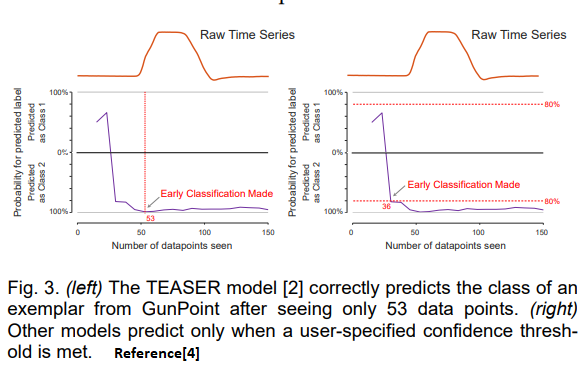


**Pros:**


*   Via ECTS, "classification without waiting for the entire pattern to appear would allow us to take immediate action in a domain in which some interventions are possible." [4]



**Cons:**


*   Can be "Disconnect to the Real World." [4].  It may not accurately represent the real world or may not be practical in some real world cases.
*   "ETSC is much harder than it appears." [4]
*   "Domains where ETSC could be meaningfully applied is vanishingly small" [4] due to: 
  *   "**The prefix problem** is the assumption that the pattern to be early classified is not a prefix of a longer innocuous pattern." [4]
  *   "**The inclusion problem** is the assumption that the pattern to be early classified is not comprised of smaller atomic units that are frequently observed on their own." [4]
  *   "**The homophone problem** is the assumption that two semantically different events will have different shapes in the time series representation." [4]
*   Susceptible to "cheating" by "peeking into the future." [4]
*   "Difficult to find data sets that make sense for ECTS." [4]

**References:**

1.   https://ieeexplore.ieee.org/document/9066213
2.   https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_early_classification.html#sphx-glr-auto-examples-classification-plot-early-classification-py
3.   https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.205.2478&rep=rep1&type=pdf
4.   https://arxiv.org/ftp/arxiv/papers/2102/2102.11487.pdf




In [ ]:
!pip install tslearn

     |████████████████████████████████| 793 kB 8.7 MB/s 


/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


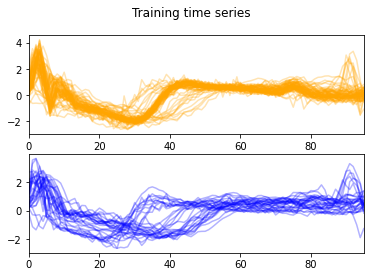

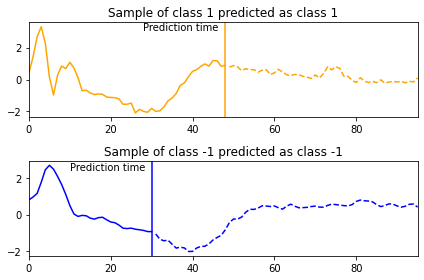

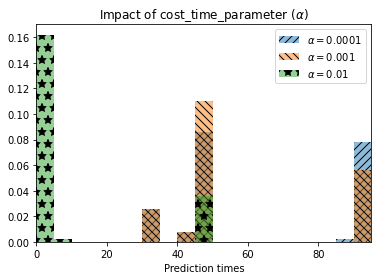

In [ ]:
# Code from Reference [2]
"""
Early Classification
====================

This example presents the concept of early classification.

Early classifiers are implemented in the 
:mod:`tslearn.early_classification` module and in this example 
we use the method from [1].


[1] A. Dachraoui, A. Bondu & A. Cornuejols. Early classification of time
series as a non myopic sequential decision making problem. ECML/PKDD 2015
"""

# Author: Romain Tavenard
# License: BSD 3 clause
# sphinx_gallery_thumbnail_number = 2

import numpy
import matplotlib.pyplot as plt

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.early_classification import NonMyopicEarlyClassifier
from tslearn.datasets import UCR_UEA_datasets

def plot_partial(time_series, t, y_true=0, y_pred=0, color="k"):
    plt.plot(time_series[:t+1].ravel(), color=color, linewidth=1.5)
    plt.plot(numpy.arange(t+1, time_series.shape[0]),
             time_series[t+1:].ravel(),
             linestyle="dashed", color=color, linewidth=1.5)
    plt.axvline(x=t, color=color, linewidth=1.5)
    plt.text(x=t - 20, y=time_series.max() - .25, s="Prediction time")
    plt.title(
        "Sample of class {} predicted as class {}".format(y_true, y_pred)
    )
    plt.xlim(0, time_series.shape[0] - 1)

##############################################################################
# Data loading and visualization
# ------------------------------

numpy.random.seed(0)
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("ECG200")

# Scale time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance().fit_transform(X_test)

size = X_train.shape[1]
n_classes = len(set(y_train))

plt.figure()
for i, cl in enumerate(set(y_train)):
    plt.subplot(n_classes, 1, i + 1)
    for ts in X_train[y_train == cl]:
        plt.plot(ts.ravel(), color="orange" if cl > 0 else "blue", alpha=.3)
    plt.xlim(0, size - 1)
plt.suptitle("Training time series")
plt.show()

##############################################################################
# Model fitting
# -------------
#
# As observed in the following figure, the optimal classification time as
# estimated by `NonMyopicEarlyClassifier` is data-dependent.

early_clf = NonMyopicEarlyClassifier(n_clusters=3,
                                     cost_time_parameter=1e-3,
                                     lamb=1e2,
                                     random_state=0)
early_clf.fit(X_train, y_train)

preds, times = early_clf.predict_class_and_earliness(X_test)

plt.figure()
plt.subplot(2, 1, 1)
ts_idx = 0
t = times[ts_idx]
plot_partial(X_test[ts_idx], t, y_test[ts_idx], preds[ts_idx], color="orange")


plt.subplot(2, 1, 2)
ts_idx = 9
t = times[ts_idx]
plot_partial(X_test[ts_idx], t, y_test[ts_idx], preds[ts_idx], color="blue")
plt.tight_layout()
plt.show()

##############################################################################
# Earliness-Accuracy trade-off
# ----------------------------
#
# The trade-off between earliness and accuracy is controlled via
# ``cost_time_parameter``.

plt.figure()
hatches = ["///", "\\\\\\", "*"]
for i, cost_t in enumerate([1e-4, 1e-3, 1e-2]):
    early_clf.set_params(cost_time_parameter=cost_t)
    early_clf.fit(X_train, y_train)
    preds, times = early_clf.predict_class_and_earliness(X_test)
    plt.hist(times,
             alpha=.5, hatch=hatches[i],
             density=True,
             label="$\\alpha={}$".format(cost_t),
             bins=numpy.arange(0, size, 5))
plt.legend(loc="upper right")
plt.xlim(0, size - 1)
plt.xlabel("Prediction times")
plt.title("Impact of cost_time_parameter ($\\alpha$)")
plt.show()